In [ ]:
# first, we'll import tools/modules we need for our pytorch models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split # easy way to deal with data

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm # nice looking progress bars
import time

In [ ]:
dtype=torch.float
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
# transform to convert image to PyTorch Tensors
transform = transforms.ToTensor()

full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


total_train = len(full_train_dataset)
train_size = int(0.7 * total_train)
val_size = total_train - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name ="Model"):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  print(f'--- Training {model_name} for {num_epochs} epochs ---')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    acc_val = 0
    total_val = 0
    running_val_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for data, target in pbar:
      data, target = data.to(device), target.to(device)

      # Step 1: zero the gradient
      optimizer.zero_grad()

      # Step 2: forward pass
      output = model(data)

      # Step 3: Calculate the loss
      loss = criterion(output, target)

      # Step 4: Backward pass
      loss.backward()

      # Step 5: Update the weifhts
      optimizer.step()

      running_loss+= loss.item()
      _, predicted = torch.max(output.data, 1)
      total +=target.size(0)
      correct += (predicted == target).sum().item()

      pbar.set_postfix({'Loss': f'{running_loss/len(train_loader)}', 'Accuracy': f'{100*correct/total}'})

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    with torch.no_grad():
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss = criterion(output, target)
        running_val_loss += val_loss.item()

        _, predicted = torch.max(output.data, 1)
        total_val += target.size(0)
        acc_val += (predicted == target).sum().item()
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = 100 * acc_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy {val_accuracy}")

  print(f'---Finished training {model_name}---')
  return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def evaulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data) # Forward pass
      _, predicted = torch.max(output, 1)
      total+= target.size(0)
      correct += (predicted == target).sum().item()

  return 100 * correct / total


In [ ]:
features, labels = next(iter(train_loader))
print(features.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
# Let's build the CNN
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(36*4*4, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 10)
  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = self.pool1(x)

    x = torch.relu(self.conv2(x))
    x = self.pool2(x)

    x = torch.relu(self.conv3(x))
    x = self.pool3(x)


    x = x.view(-1, 36*4*4)

    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model_cnn = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()
print(model_cnn)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
cnn_losses, cnn_accuracies, val_losses, val_accuracies = train_model(model_cnn, train_loader, val_loader,criterion, optimizer_cnn, num_epochs=10, model_name="CNN on FashionMNIST")
cnn_cifar_accuracy = evaulate_model(model_cnn, test_loader)
print(f'Accuracy of the CNN on FashionMNIST-10: {cnn_cifar_accuracy:.2f}%')

--- Training CNN on FashionMNIST for 10 epochs ---


Epoch 1/10: 100%|██████████| 657/657 [00:07<00:00, 88.91it/s, Loss=0.7203335011295714, Accuracy=73.28571428571429]


Validation Accuracy 84.12777777777778


Epoch 2/10: 100%|██████████| 657/657 [00:07<00:00, 89.62it/s, Loss=0.37895477471286304, Accuracy=86.03571428571429]


Validation Accuracy 87.85555555555555


Epoch 3/10: 100%|██████████| 657/657 [00:06<00:00, 95.00it/s, Loss=0.31277825283042554, Accuracy=88.18809523809524]


Validation Accuracy 89.10555555555555


Epoch 4/10: 100%|██████████| 657/657 [00:07<00:00, 89.98it/s, Loss=0.27788877859144634, Accuracy=89.54047619047618]


Validation Accuracy 90.2611111111111


Epoch 5/10: 100%|██████████| 657/657 [00:07<00:00, 88.90it/s, Loss=0.2510425012496327, Accuracy=90.49761904761905]


Validation Accuracy 90.88333333333334


Epoch 6/10: 100%|██████████| 657/657 [00:07<00:00, 89.80it/s, Loss=0.23276773255029226, Accuracy=91.28095238095239]


Validation Accuracy 90.91111111111111


Epoch 7/10: 100%|██████████| 657/657 [00:06<00:00, 94.85it/s, Loss=0.21465774220123865, Accuracy=91.84285714285714]


Validation Accuracy 91.27222222222223


Epoch 8/10: 100%|██████████| 657/657 [00:07<00:00, 89.85it/s, Loss=0.19860116988307083, Accuracy=92.45]


Validation Accuracy 91.57222222222222


Epoch 9/10: 100%|██████████| 657/657 [00:07<00:00, 87.80it/s, Loss=0.1858797656766265, Accuracy=93.06190476190476]


Validation Accuracy 91.86111111111111


Epoch 10/10: 100%|██████████| 657/657 [00:07<00:00, 88.55it/s, Loss=0.1701923674440275, Accuracy=93.62142857142857]


Validation Accuracy 91.86666666666666
---Finished training CNN on FashionMNIST---
Accuracy of the CNN on FashionMNIST-10: 91.01%


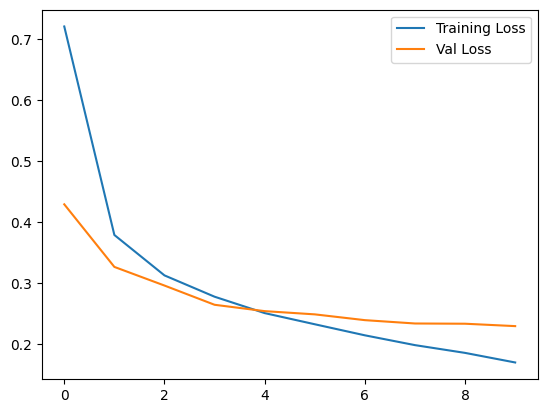

In [ ]:
plt.plot(cnn_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()